# Notebook 02 – Feature Selection

**Pipeline stages covered:**
1. Load cleaned dataset from Notebook 01
2. Stratified train / test split (80 / 20) — **the authoritative split**
3. Fit MinMaxScaler **on training data only** (no leakage)
4. Random Forest feature selection (Gini impurity, top 20)
5. Visualize feature importances & correlation heatmap
6. Persist: scaler, split indices, selected features

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import joblib

from utils.preprocessing    import (
    split_features_labels,
    fit_scaler,
    transform_features,
    fit_label_encoder,
    encode_labels,
    get_label_mapping,
)
from utils.feature_selection import select_features_rf, save_selected_features
from utils.visualization     import (
    plot_feature_importance,
    plot_all_feature_importance,
    plot_correlation_heatmap,
    plot_feature_distributions,
)

print('✓ Imports OK')

✓ Imports OK


In [2]:
# ── Configuration ──────────────────────────────────────────────────────────
DATA_DIR      = '../data/processed'
OUTPUT_DIR    = '../data/processed'
MODEL_DIR     = '../model'
LABEL_COL     = 'Label'
N_FEATURES    = 20       # top-K features to select
TEST_SIZE     = 0.20
RANDOM_STATE  = 42
RF_ESTIMATORS = 100

os.makedirs(MODEL_DIR, exist_ok=True)

## 1 · Load Cleaned Dataset

In [3]:
df = pd.read_parquet(f'{DATA_DIR}/cleaned_dataset.parquet')
print(f'Loaded dataset: {df.shape[0]:,} rows × {df.shape[1]} cols')

X, y, feature_names = split_features_labels(df, label_col=LABEL_COL)
print(f'Features: {len(feature_names)}  |  Classes: {y.nunique()}')

Loaded dataset: 1,799,029 rows × 73 cols
Features: 72  |  Classes: 12


## 2 · Stratified Train / Test Split (80 / 20)

> This is the **canonical** split. Both the scaler and the Random Forest
> are fitted **only on `X_train`** to prevent data leakage.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(f'Training samples  : {len(X_train):,}  ({len(X_train)/len(X)*100:.1f}%)')
print(f'Test samples      : {len(X_test):,}  ({len(X_test)/len(X)*100:.1f}%)')

Training samples  : 1,439,223  (80.0%)
Test samples      : 359,806  (20.0%)


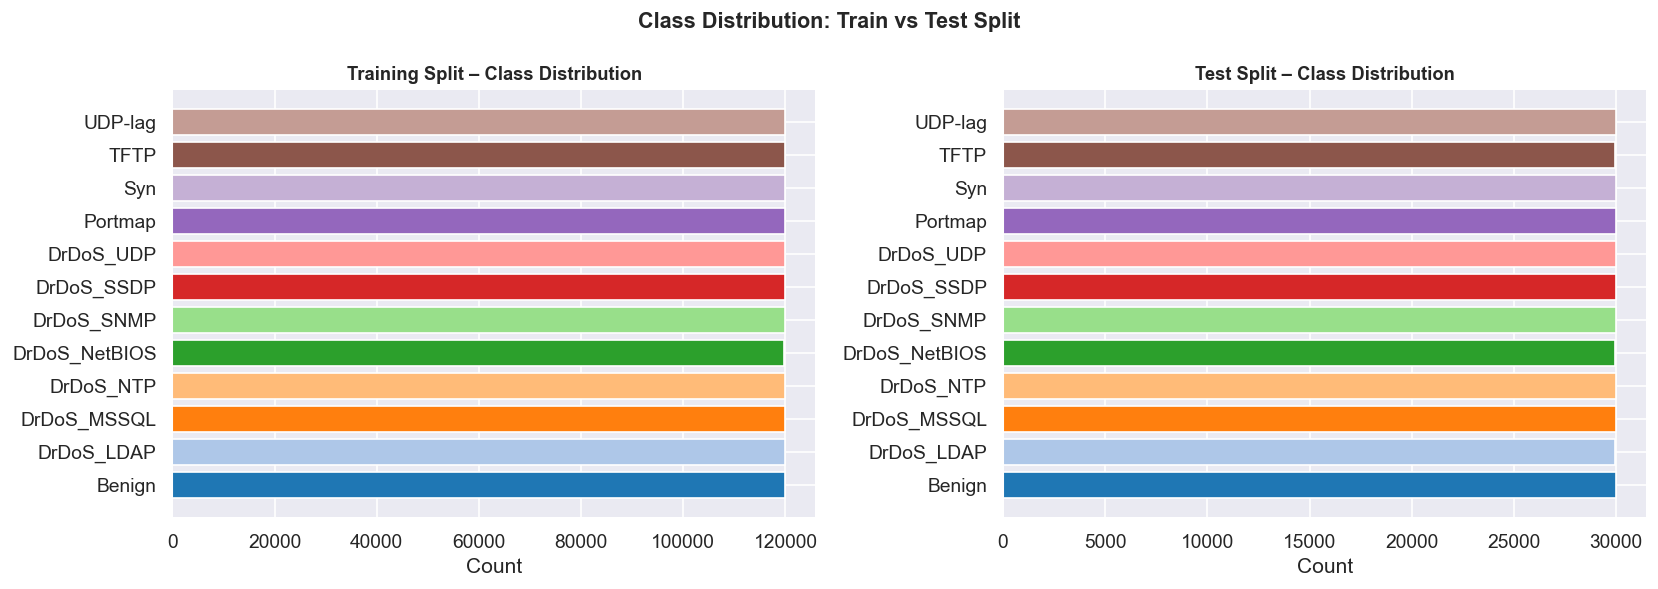

In [5]:
# Visualise split class balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

colors = plt.cm.tab20.colors
ax1.barh(train_counts.index, train_counts.values, color=colors[:len(train_counts)])
ax1.set_title('Training Split – Class Distribution', fontsize=11, fontweight='bold')
ax1.set_xlabel('Count')

ax2.barh(test_counts.index, test_counts.values, color=colors[:len(test_counts)])
ax2.set_title('Test Split – Class Distribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Count')

plt.suptitle('Class Distribution: Train vs Test Split', fontsize=13, fontweight='bold')
plt.tight_layout()
fig.savefig(f'{OUTPUT_DIR}/fig_07_split_dist.png', dpi=120, bbox_inches='tight')
plt.show()

## 3 · Label Encoding (One-Hot)

Encoder fitted **only on `y_train`**.

In [6]:
label_encoder = fit_label_encoder(y_train)
y_train_enc   = encode_labels(label_encoder, y_train)
y_test_enc    = encode_labels(label_encoder, y_test)

class_names = label_encoder.classes_.tolist()
print(f'Classes: {class_names}')
print(f'y_train_enc shape: {y_train_enc.shape}')
print(f'y_test_enc  shape: {y_test_enc.shape}')

# Show encoded mapping
mapping = get_label_mapping(label_encoder)
print('\nOne-hot mapping:')
for cls, vec in mapping.items():
    print(f'  {cls:<30} → {vec}')

# Save encoder
joblib.dump(label_encoder, f'{MODEL_DIR}/label_encoder.pkl')
print(f'\n✓ label_encoder saved → {MODEL_DIR}/label_encoder.pkl')

Classes: ['Benign', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Portmap', 'Syn', 'TFTP', 'UDP-lag']
y_train_enc shape: (1439223, 12)
y_test_enc  shape: (359806, 12)

One-hot mapping:
  Benign                         → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_LDAP                     → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_MSSQL                    → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NTP                      → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_NetBIOS                  → [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  DrDoS_SNMP                     → [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  DrDoS_SSDP                     → [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  DrDoS_UDP                      → [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  Portmap                        → [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  Syn                            → [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  TFTP                           → [0, 0

## 4 · Feature Scaling (MinMax 0–1)

Scaler fitted **only on `X_train`**.

In [7]:
scaler      = fit_scaler(X_train)
X_train_sc  = transform_features(scaler, X_train)
X_test_sc   = transform_features(scaler, X_test)

print(f'Scaler fitted on {len(X_train):,} training samples.')
print(f'X_train_sc range: [{X_train_sc.min():.4f}, {X_train_sc.max():.4f}]')
print(f'X_test_sc  range: [{X_test_sc.min():.4f}, {X_test_sc.max():.4f}]')

# Persist scaler
joblib.dump(scaler, f'{MODEL_DIR}/scaler.pkl')
print(f'\n✓ Scaler saved → {MODEL_DIR}/scaler.pkl')

Scaler fitted on 1,439,223 training samples.
X_train_sc range: [0.0000, 1.0000]
X_test_sc  range: [0.0000, 1.0483]

✓ Scaler saved → ../model/scaler.pkl


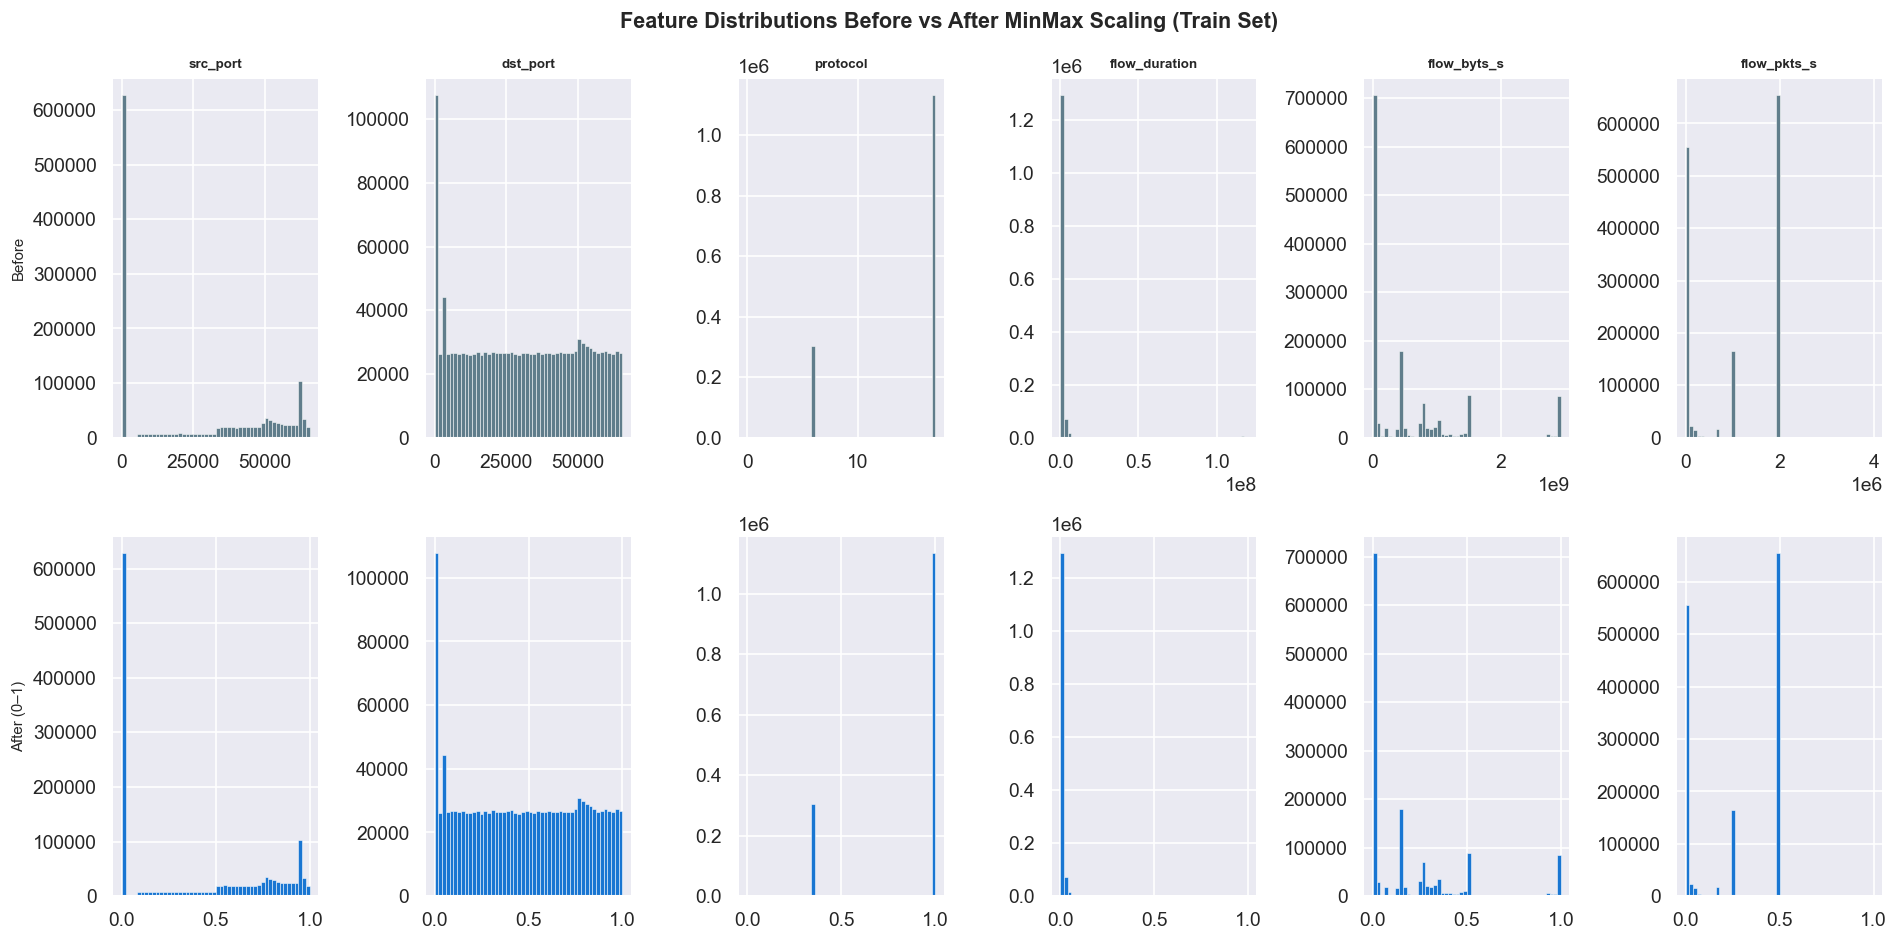

In [8]:
# Feature distributions before vs after scaling
fig = plot_feature_distributions(
    X_raw=X_train,
    X_scaled=X_train_sc,
    feature_names=feature_names,
    n_features=6,
    title='Feature Distributions Before vs After MinMax Scaling (Train Set)',
)
fig.savefig(f'{OUTPUT_DIR}/fig_08_scaling_dist.png', dpi=120, bbox_inches='tight')
plt.show()

## 5 · Random Forest Feature Selection (Top 20)

The RF is trained **only on `X_train_sc`** and `y_train`.

In [9]:
selected_features, importances_df, rf_model = select_features_rf(
    X_train=X_train_sc,
    y_train_raw=y_train,
    feature_names=feature_names,
    n_features=N_FEATURES,
    n_estimators=RF_ESTIMATORS,
    random_state=RANDOM_STATE,
)

print(f'\nSelected {len(selected_features)} features:')
for i, f in enumerate(selected_features, 1):
    print(f'  {i:>2}. {f}')

[feature_selection] Training Random Forest with 100 trees …
[feature_selection] Top 20 features selected:
          feature  importance
         src_port    0.119655
  fwd_pkt_len_max    0.076736
     pkt_size_avg    0.070181
     pkt_len_mean    0.069266
      pkt_len_min    0.067872
      pkt_len_max    0.063343
  fwd_pkt_len_min    0.057658
  totlen_fwd_pkts    0.057546
 fwd_pkt_len_mean    0.055203
         dst_port    0.053145
      flow_byts_s    0.034866
fwd_act_data_pkts    0.026244
      flow_pkts_s    0.025715
     tot_fwd_pkts    0.022372
       fwd_pkts_s    0.021185
init_fwd_win_byts    0.020664
         protocol    0.014571
    flow_duration    0.012410
     flow_iat_max    0.011581
     flow_iat_std    0.009677

Selected 20 features:
   1. src_port
   2. fwd_pkt_len_max
   3. pkt_size_avg
   4. pkt_len_mean
   5. pkt_len_min
   6. pkt_len_max
   7. fwd_pkt_len_min
   8. totlen_fwd_pkts
   9. fwd_pkt_len_mean
  10. dst_port
  11. flow_byts_s
  12. fwd_act_data_pkts
  13. 

## 6 · Visualize Feature Importances

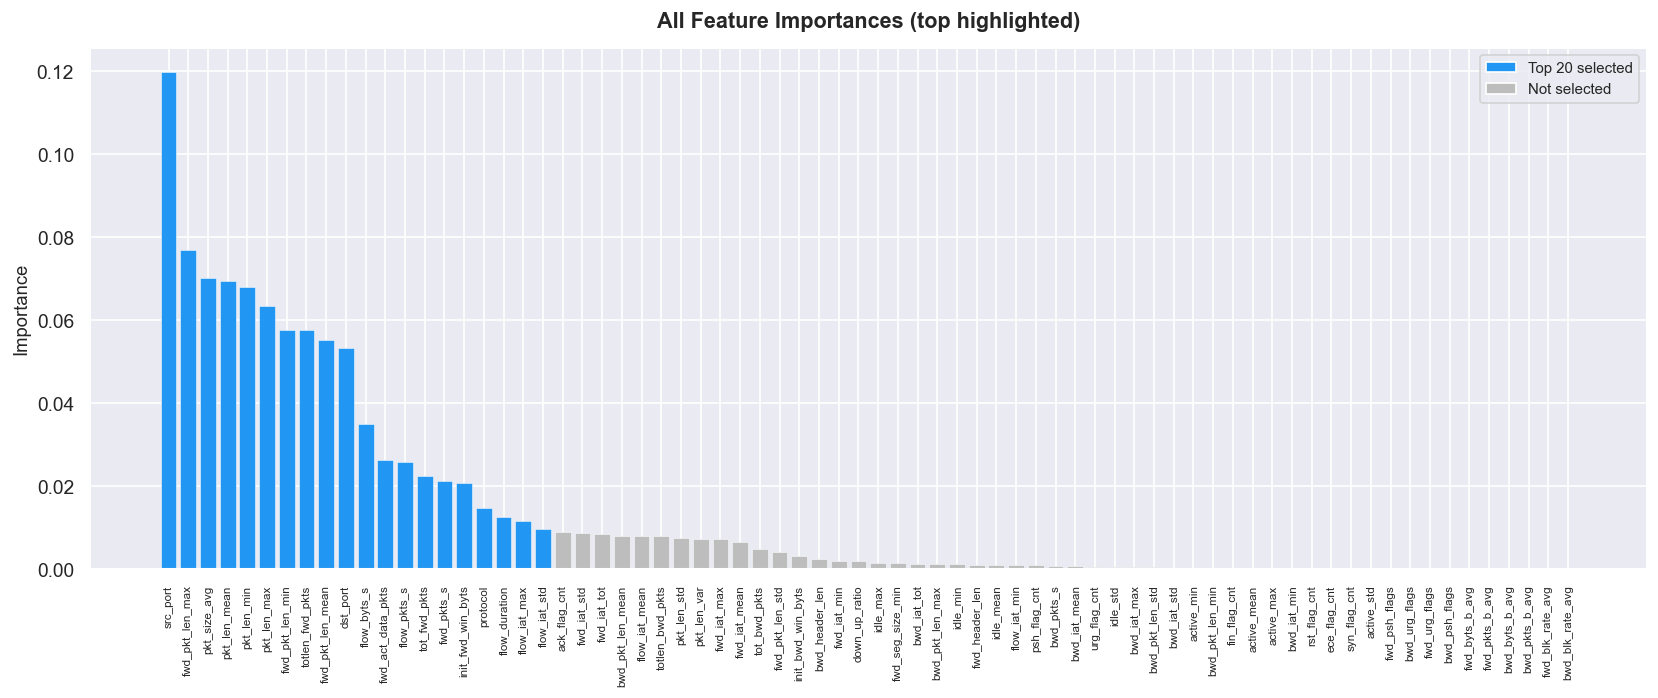

In [10]:
# All features – top highlighted
fig = plot_all_feature_importance(importances_df, n_top=N_FEATURES)
fig.savefig(f'{OUTPUT_DIR}/fig_09_all_importances.png', dpi=120, bbox_inches='tight')
plt.show()

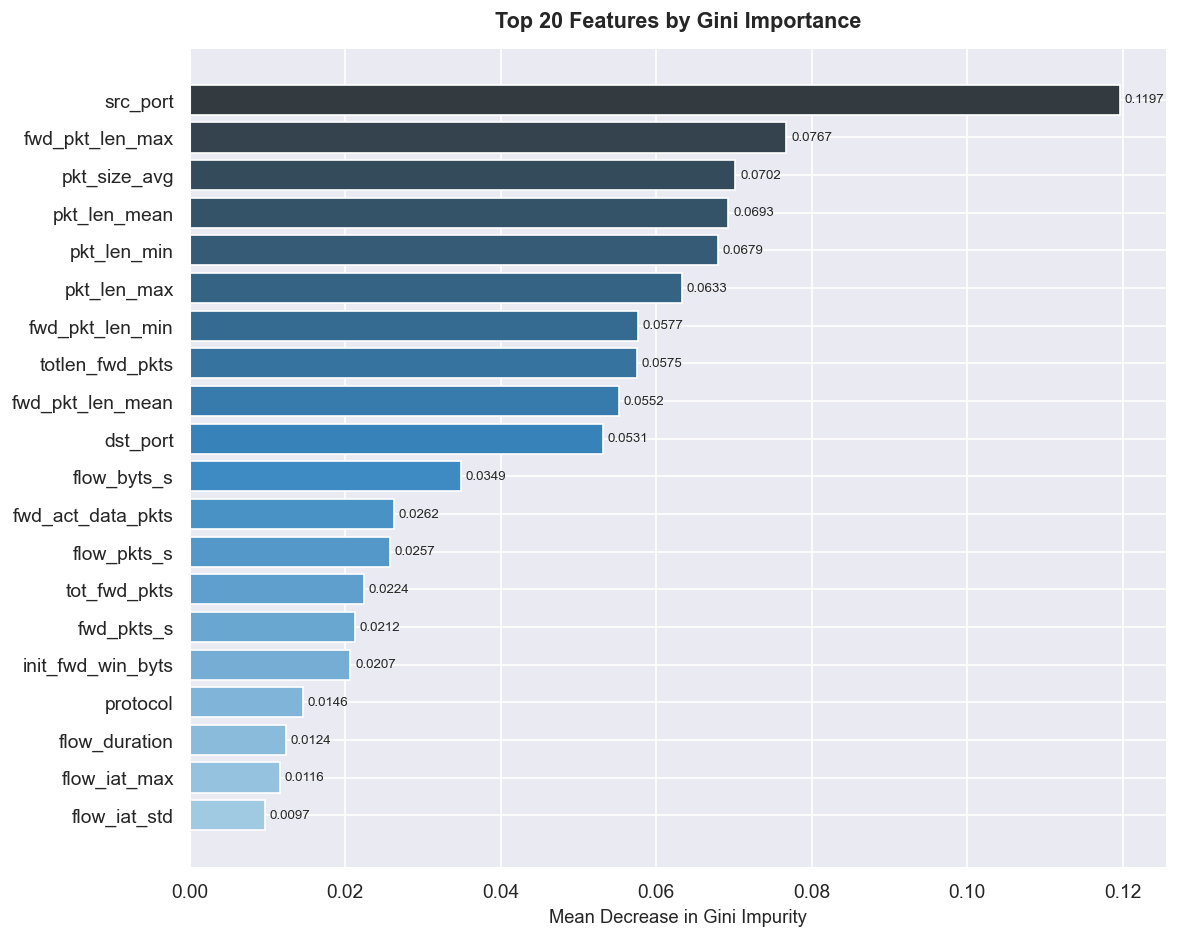

In [11]:
# Top-20 features detailed view
fig = plot_feature_importance(importances_df, n_features=N_FEATURES,
                               title=f'Top {N_FEATURES} Features by Gini Importance')
fig.savefig(f'{OUTPUT_DIR}/fig_10_top20_importance.png', dpi=120, bbox_inches='tight')
plt.show()

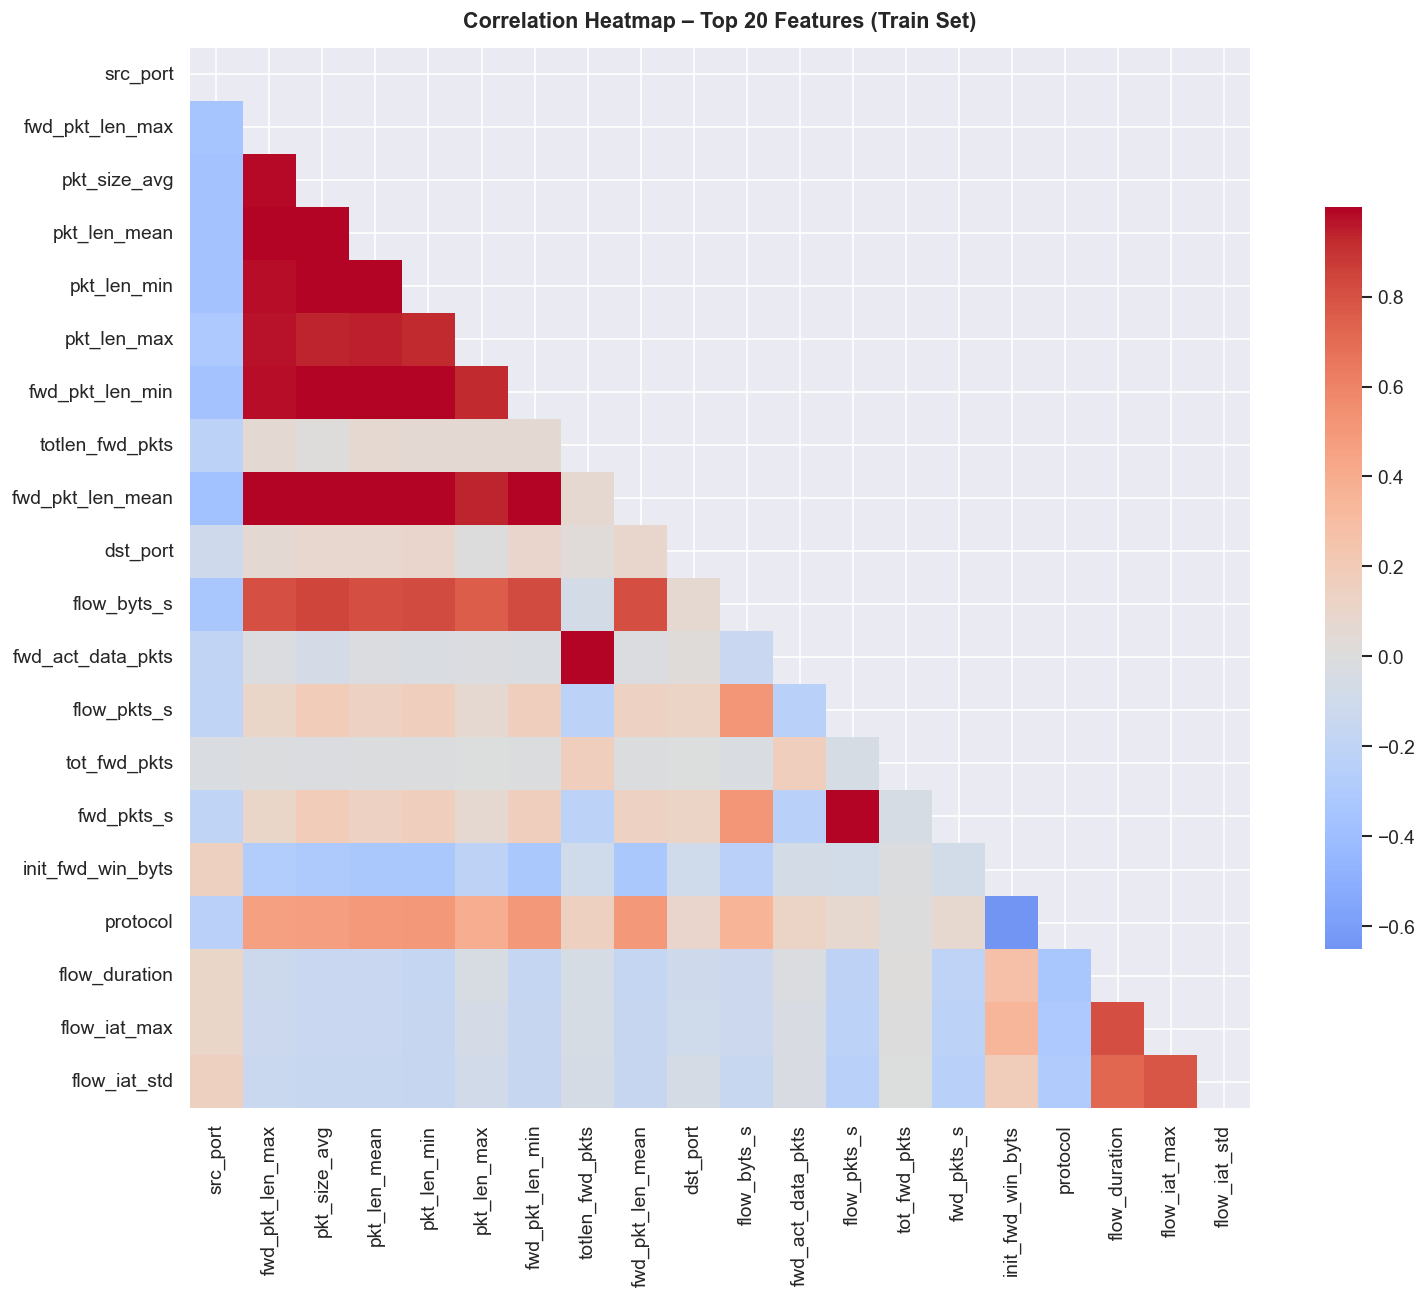

In [12]:
# Correlation heatmap of the top-20 features (training set only)
train_df_top20 = pd.DataFrame(X_train_sc, columns=feature_names)[selected_features]
fig = plot_correlation_heatmap(train_df_top20,
                                title='Correlation Heatmap – Top 20 Features (Train Set)')
fig.savefig(f'{OUTPUT_DIR}/fig_11_correlation.png', dpi=120, bbox_inches='tight')
plt.show()

## 7 · Persist Artifacts

In [ ]:
# Save selected features list
save_selected_features(selected_features, f'{MODEL_DIR}/selected_features.json')

# Save processed splits as compressed numpy arrays (indexed by original position)
feat_idx = [feature_names.index(f) for f in selected_features]

np.save(f'{OUTPUT_DIR}/X_train_sc.npy', X_train_sc[:, feat_idx])
np.save(f'{OUTPUT_DIR}/X_test_sc.npy',  X_test_sc[:, feat_idx])
np.save(f'{OUTPUT_DIR}/y_train_enc.npy', y_train_enc)
np.save(f'{OUTPUT_DIR}/y_test_enc.npy',  y_test_enc)

# Save raw label arrays for metrics computation later
y_train.reset_index(drop=True).to_json(f'{OUTPUT_DIR}/y_train_raw.json')
y_test.reset_index(drop=True).to_json(f'{OUTPUT_DIR}/y_test_raw.json')

# Save metadata
meta = {
    'n_features' : N_FEATURES,
    'n_classes'  : len(class_names),
    'class_names': class_names,
    'selected_features': selected_features,
    'test_size'  : TEST_SIZE,
    'random_state': RANDOM_STATE,
}
with open(f'{OUTPUT_DIR}/metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print('✓ All artifacts saved:')
print(f'   {MODEL_DIR}/selected_features.json')
print(f'   {MODEL_DIR}/scaler.pkl')
print(f'   {MODEL_DIR}/label_encoder.pkl')
print(f'   {OUTPUT_DIR}/X_train_sc.npy / X_test_sc.npy')
print(f'   {OUTPUT_DIR}/y_train_enc.npy / y_test_enc.npy')
print(f'   {OUTPUT_DIR}/metadata.json')

[feature_selection] Selected features saved → ../model/selected_features.json
✓ All artifacts saved:
   ../model/selected_features.json
   ../model/scaler.pkl
   ../model/label_encoder.pkl
   ../data/processed/X_train_sc.npy / X_test_sc.npy
   ../data/processed/y_train_enc.npy / y_test_enc.npy
   ../data/processed/metadata.json


: 